In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM,BatchNormalization
from tensorflow import keras

note that change the data source


In [2]:
data = pd.read_csv("D:\\học đại học\\20222\\machine learning\\saved_data.csv")

In [3]:
time=data['Date']
data=data.drop('Date', axis=1)
target="BTC_close"


In [4]:
data.head()

,BTC_close,BTC_open,BTC_high,BTC_low,BTC_volume,Active_Addr_Cnt,Difficulty,Mean_Block_Size(in_bytes),Sum_Block_Weight,Total_Fees(USD),...,ETH,LTC,DOGE,XRP,GOLD,SILVER,COPPER,S&P500,DJI,JP225
0,0.1,0.1,0.1,0.1,0.26,936.0,182.0,1090.745856,789700.0,0.000000,...,0.0,0.0,0.0,0.0,1191.7,17.693,0.00,1083.48,10229.96,9300.46
1,0.1,0.1,0.1,0.1,0.58,784.0,182.0,603.821256,499964.0,0.000000,...,0.0,0.0,0.0,0.0,1191.8,17.803,0.00,1069.59,10120.53,9278.83
2,0.1,0.1,0.1,0.1,2.16,594.0,182.0,572.443182,403000.0,0.000000,...,0.0,0.0,0.0,0.0,1195.6,18.120,7002.75,1093.67,10322.30,9220.88
3,0.1,0.1,0.1,0.1,2.40,655.0,182.0,530.932990,412004.0,0.000606,...,0.0,0.0,0.0,0.0,1187.8,18.101,7018.25,1102.66,10424.62,9430.96
4,0.1,0.1,0.1,0.1,0.50,959.0,182.0,1519.539683,1148772.0,0.000000,...,0.0,0.0,0.0,0.0,1187.8,18.101,7018.25,1102.66,10424.62,9430.96


In [5]:
data.columns

Index(['BTC_close', 'BTC_open', 'BTC_high', 'BTC_low', 'BTC_volume',
       'Active_Addr_Cnt', 'Difficulty', 'Mean_Block_Size(in_bytes)',
       'Sum_Block_Weight', 'Total_Fees(USD)', 'Mean_Hashrate', 'Xfer_Cnt',
       'Mean_Tx_size(native_units)', 'ETH', 'LTC', 'DOGE', 'XRP', 'GOLD',
       'SILVER', 'COPPER', 'S&P500', 'DJI', 'JP225'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


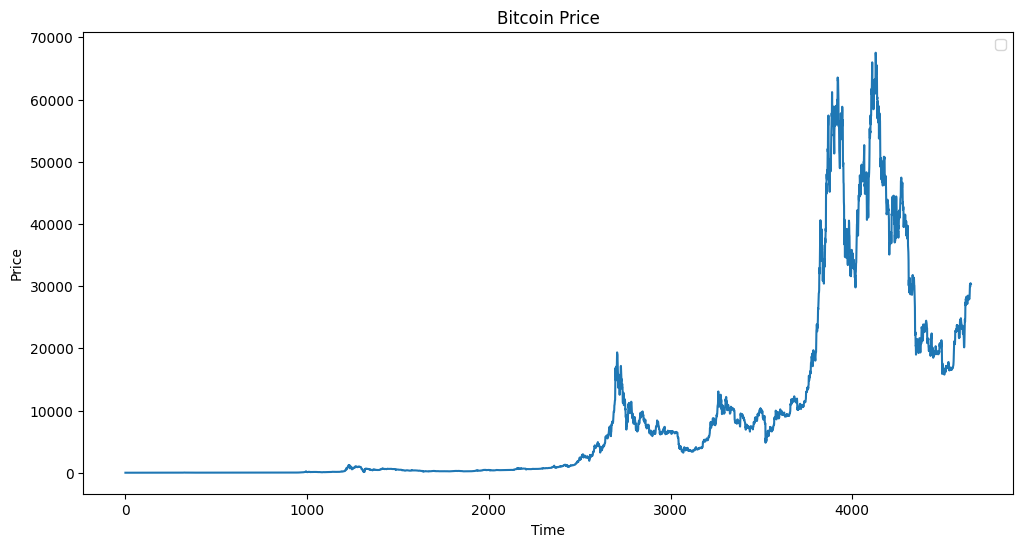

In [6]:
plt.figure(figsize=(12, 6))

plt.plot(data[target])

plt.title('Bitcoin Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [7]:
target=np.array(target)
target.shape

()

splitting data to train, valid, test set

In [8]:
train_data= data.copy().iloc[:int(0.7*len(data)),:]
train_np= train_data.to_numpy()
val_data=data.copy().iloc[int(0.7*len(data)):int(0.85*len(data)),:]
val_np=val_data.to_numpy()
test_data=data.copy().iloc[int(0.85*len(data)):,:]
test_np=test_data.to_numpy()

In [9]:
train_time=time[:int(0.7*len(data))]
val_time=time[int(0.7*len(data)):int(0.85*len(data))]
test_time=time[int(0.85*len(data)):]

In [10]:
train_np = np.asarray(train_np).astype('float32')
val_np = np.asarray(val_np).astype('float32')
test_np = np.asarray(test_np).astype('float32')

In [83]:
time_step=40
train_time_line=[]
val_time_line=[]
test_time_line=[]

**Create data sequence, sequence length is time step and predict y is the right next day**

In [84]:
def scale_sequence_data(df,timesteps ,close_col_idx):
    x = []
    y = []
    timeLine=[]
    for i in range(len(df)-timesteps):    
        scaler=MinMaxScaler()      
        scaler.fit(df[i:i+timesteps,:])
        timeLine.append((scaler.data_min_[close_col_idx],scaler.data_max_[close_col_idx]))
        x.append(scaler.transform(df[i:i+timesteps,:]))
        value=df[i+timesteps].reshape(1,-1)
        value=scaler.transform(value)
        y.append(value[:,close_col_idx])

    return np.array(x),np.array(y),timeLine


In [85]:
train_x, train_y,train_time_line = scale_sequence_data(train_np, time_step,data.columns.get_loc('BTC_close'))
val_x,val_y,val_time_line =scale_sequence_data(val_np,time_step ,data.columns.get_loc('BTC_close'))
test_x, test_y,test_time_line = scale_sequence_data(test_np, time_step,data.columns.get_loc('BTC_close'))

**Build Model**

In [86]:

model = Sequential()
model.add(LSTM(units=128,return_sequences=True,recurrent_dropout=0.3))
model.add(LSTM(units=128,return_sequences =True,recurrent_dropout=0.3))
model.add(LSTM(units=64,return_sequences=False,recurrent_dropout=0.3))
model.add(Dense(1,activation='tanh'))
moniter=keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model.compile(optimizer='adam',loss='MeanSquaredError')
model.fit(train_x,train_y,epochs=1, batch_size=32,validation_data=(val_x,val_y),callbacks=[moniter])
model.summary()

101/101 [==============================] - 22s 122ms/step - loss: 0.0771 - val_loss: 0.0527
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 40, 128)           77824     
                                                                 
 lstm_16 (LSTM)              (None, 40, 128)           131584    
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 258881 (1011.25 KB)
Trainable params: 258881 (1011.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [87]:
model.compile(optimizer='adam',loss='MeanSquaredError')
model.fit(train_x,train_y,epochs=50, batch_size=32,validation_data=(val_x,val_y),callbacks=[moniter])

Epoch 1/50
101/101 [==============================] - 21s 124ms/step - loss: 0.0390 - val_loss: 0.0304
Epoch 2/50
101/101 [==============================] - 12s 116ms/step - loss: 0.0299 - val_loss: 0.0270
Epoch 3/50
101/101 [==============================] - 12s 114ms/step - loss: 0.0270 - val_loss: 0.0248
Epoch 4/50
101/101 [==============================] - 12s 119ms/step - loss: 0.0249 - val_loss: 0.0263
Epoch 5/50
101/101 [==============================] - 12s 120ms/step - loss: 0.0242 - val_loss: 0.0238
Epoch 6/50
101/101 [==============================] - 12s 118ms/step - loss: 0.0233 - val_loss: 0.0243
Epoch 7/50
101/101 [==============================] - 12s 118ms/step - loss: 0.0230 - val_loss: 0.0237
Epoch 8/50
101/101 [==============================] - 12s 119ms/step - loss: 0.0223 - val_loss: 0.0225
Epoch 9/50
101/101 [==============================] - 13s 128ms/step - loss: 0.0214 - val_loss: 0.0229
Epoch 10/50
101/101 [==============================] - 10s 101ms/step - l

In [88]:
model.evaluate(train_x,train_y)
model.evaluate(val_x,val_y)
model.evaluate(test_x,test_y)

21/21 [==============================] - 0s 20ms/step - loss: 0.0223


0.02230237051844597

In [96]:

prec_train=model.predict(train_x)
pre_val=model.predict(val_x)
predictions = model.predict(test_x)
test_y=test_y.reshape(-1,1)

21/21 [==============================] - 1s 27ms/step


In [91]:
def inverseTransform(value, timeline):
    result = []
    for i in range(len(timeline)):
        min_val = timeline[i][0]
        max_val = timeline[i][1]
        original_value = (value[i] * (max_val - min_val)) + min_val
        result.append(original_value)
    return np.array(result)


In [92]:
predic_after_inverse=inverseTransform(predictions,test_time_line)
true_after_inverse=inverseTransform(test_y,test_time_line)
inverse_train_pred=inverseTransform(prec_train,train_time_line)
inverse_train_true=inverseTransform(train_y,train_time_line)

**Evaluating accuracy of model by RMSE,MAPE, ACC**

In [93]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
import numpy as np
true_train=inverse_train_true 
prediction_train=inverse_train_pred
prediction_test=predic_after_inverse
true_test=true_after_inverse
def calculate_acc(true_values, predicted_values):
    count = 0
    for i in range(1, len(true_values)):
        if (true_values[i] - true_values[i-1]) * (predicted_values[i] - predicted_values[i-1]) > 0:
            count += 1
    return count / (len(true_values) - 1)

def print_evaluation_results(true_values, predicted_values, dataset_name):
    print("Test accuracy for", dataset_name)
    print("------------------------------------------------------")
    # RMSE
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    print("Root Mean Square Error (RMSE): {:.4f}".format(rmse))
    
    # MAPE
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    print("Mean Absolute Percentage Error (MAPE): {:.4f}".format(mape))
    
    # ACC
    acc = calculate_acc(true_values, predicted_values)
    print("ACC test: {:.4f}".format(acc))
    print()

# Print evaluation results for the train set
print_evaluation_results(true_train, prediction_train, "train set")

# Print evaluation results for the test set
print_evaluation_results(true_test, prediction_test, "test set")


Test accuracy for train set
------------------------------------------------------
Root Mean Square Error (RMSE): 197.1692
Mean Absolute Percentage Error (MAPE): 0.0368
ACC test: 0.4521

Test accuracy for test set
------------------------------------------------------
Root Mean Square Error (RMSE): 1299.5831
Mean Absolute Percentage Error (MAPE): 0.0264
ACC test: 0.4453



**Problem Visualization**

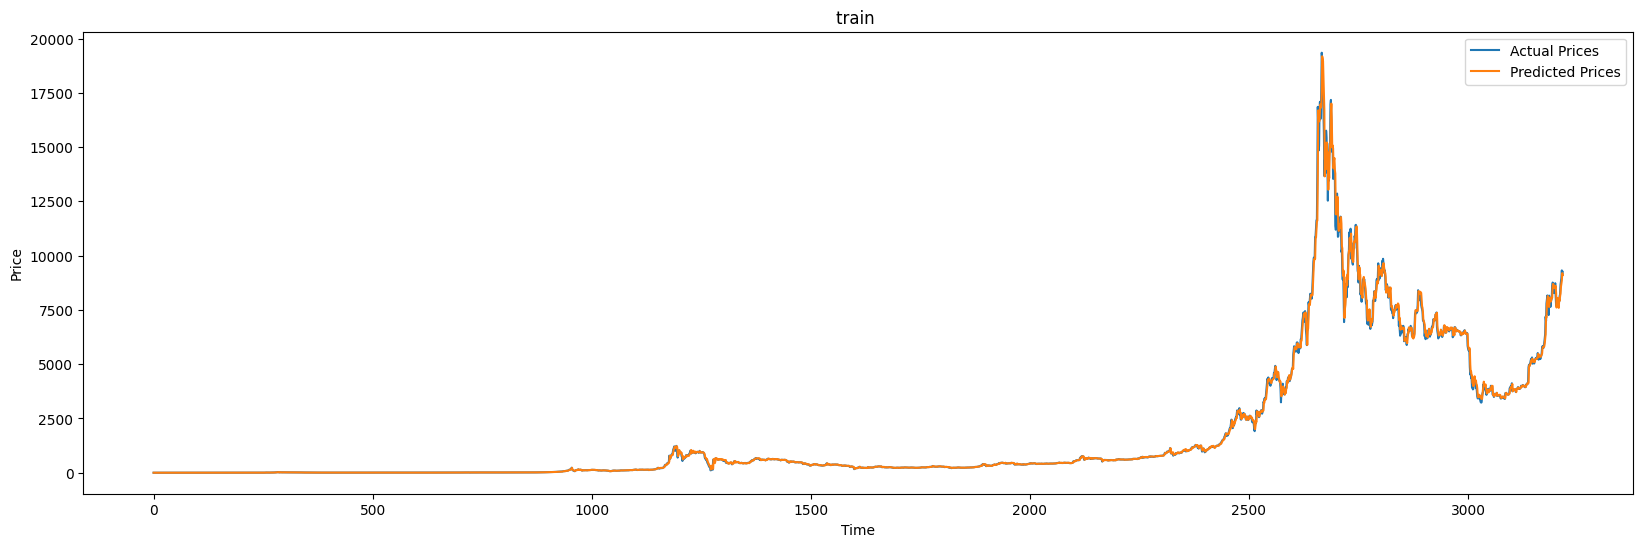

In [94]:

# Plot the predicted and actual prices
plt.figure(figsize=(20,6))
plt.plot(inverse_train_true, label='Actual Prices')
plt.plot(inverse_train_pred, label='Predicted Prices')

plt.title('train ')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

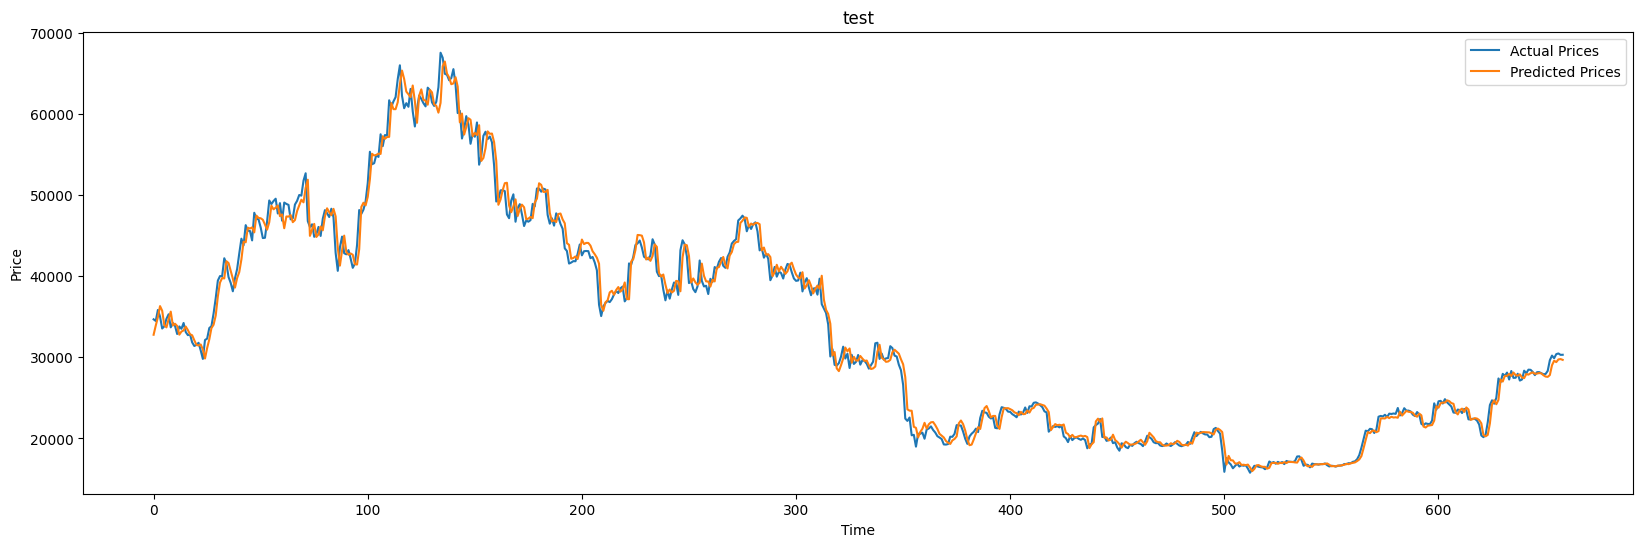

In [95]:

# Plot the predicted and actual prices
plt.figure(figsize=(20,6))
plt.plot(true_after_inverse, label='Actual Prices')
plt.plot(predic_after_inverse, label='Predicted Prices')

plt.title('test')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()